In [1]:
# Imports
import os
import tensorflow as tf
from tensorflow.keras import callbacks, preprocessing, optimizers, utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
import matplotlib.pyplot as plt

####
import cv2 as cv
from tqdm import tqdm
from tifffile import imwrite, imread
####

import sys
sys.path.append('code')
import UNet
import CTUNet
from Loss_Metrics import jaccard_coef, jaccard_coef_loss, dice_coef_loss, binary_cross_iou
sys.path.append('../')

In [2]:
train_set = 'rgbLiDAR'
input_shape = (512, 512, 4)
weight = None
mask = 'mask'

In [3]:
model = UNet.EfficientNetB4_unet(input_shape, weight)
model.summary()
model.compile(optimizer=optimizers.Adam(learning_rate=0.000015), loss=[dice_coef_loss], metrics=[jaccard_coef, 'accuracy'])

Model: "EfficientNetB4_U-Net"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 4  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 512, 512, 4)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 512, 512, 4)  9           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPadding2D)  (None, 513, 513, 4)  0           ['normalizatio

                                                                                                  
 block2a_expand_bn (BatchNormal  (None, 256, 256, 14  576        ['block2a_expand_conv[0][0]']    
 ization)                       4)                                                                
                                                                                                  
 block2a_expand_activation (Act  (None, 256, 256, 14  0          ['block2a_expand_bn[0][0]']      
 ivation)                       4)                                                                
                                                                                                  
 block2a_dwconv_pad (ZeroPaddin  (None, 257, 257, 14  0          ['block2a_expand_activation[0][0]
 g2D)                           4)                               ']                               
                                                                                                  
 block2a_d

 ization)                       2)                                                                
                                                                                                  
 block2c_expand_activation (Act  (None, 128, 128, 19  0          ['block2c_expand_bn[0][0]']      
 ivation)                       2)                                                                
                                                                                                  
 block2c_dwconv (DepthwiseConv2  (None, 128, 128, 19  1728       ['block2c_expand_activation[0][0]
 D)                             2)                               ']                               
                                                                                                  
 block2c_bn (BatchNormalization  (None, 128, 128, 19  768        ['block2c_dwconv[0][0]']         
 )                              2)                                                                
          

 block3a_expand_bn (BatchNormal  (None, 128, 128, 19  768        ['block3a_expand_conv[0][0]']    
 ization)                       2)                                                                
                                                                                                  
 block3a_expand_activation (Act  (None, 128, 128, 19  0          ['block3a_expand_bn[0][0]']      
 ivation)                       2)                                                                
                                                                                                  
 block3a_dwconv_pad (ZeroPaddin  (None, 131, 131, 19  0          ['block3a_expand_activation[0][0]
 g2D)                           2)                               ']                               
                                                                                                  
 block3a_dwconv (DepthwiseConv2  (None, 64, 64, 192)  4800       ['block3a_dwconv_pad[0][0]']     
 D)       

 D)                                                              ']                               
                                                                                                  
 block3c_bn (BatchNormalization  (None, 64, 64, 336)  1344       ['block3c_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block3c_activation (Activation  (None, 64, 64, 336)  0          ['block3c_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block3c_se_squeeze (GlobalAver  (None, 336)         0           ['block3c_activation[0][0]']     
 agePooling2D)                                                                                    
          

 block4a_bn (BatchNormalization  (None, 32, 32, 336)  1344       ['block4a_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block4a_activation (Activation  (None, 32, 32, 336)  0          ['block4a_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block4a_se_squeeze (GlobalAver  (None, 336)         0           ['block4a_activation[0][0]']     
 agePooling2D)                                                                                    
                                                                                                  
 block4a_se_reshape (Reshape)   (None, 1, 1, 336)    0           ['block4a_se_squeeze[0][0]']     
          

                                                                                                  
 block4c_se_reduce (Conv2D)     (None, 1, 1, 28)     18844       ['block4c_se_reshape[0][0]']     
                                                                                                  
 block4c_se_expand (Conv2D)     (None, 1, 1, 672)    19488       ['block4c_se_reduce[0][0]']      
                                                                                                  
 block4c_se_excite (Multiply)   (None, 32, 32, 672)  0           ['block4c_activation[0][0]',     
                                                                  'block4c_se_expand[0][0]']      
                                                                                                  
 block4c_project_conv (Conv2D)  (None, 32, 32, 112)  75264       ['block4c_se_excite[0][0]']      
                                                                                                  
 block4c_p

 block4e_se_excite (Multiply)   (None, 32, 32, 672)  0           ['block4e_activation[0][0]',     
                                                                  'block4e_se_expand[0][0]']      
                                                                                                  
 block4e_project_conv (Conv2D)  (None, 32, 32, 112)  75264       ['block4e_se_excite[0][0]']      
                                                                                                  
 block4e_project_bn (BatchNorma  (None, 32, 32, 112)  448        ['block4e_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block4e_drop (Dropout)         (None, 32, 32, 112)  0           ['block4e_project_bn[0][0]']     
                                                                                                  
 block4e_a

 block5a_project_bn (BatchNorma  (None, 32, 32, 160)  640        ['block5a_project_conv[0][0]']   
 lization)                                                                                        
                                                                                                  
 block5b_expand_conv (Conv2D)   (None, 32, 32, 960)  153600      ['block5a_project_bn[0][0]']     
                                                                                                  
 block5b_expand_bn (BatchNormal  (None, 32, 32, 960)  3840       ['block5b_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5b_expand_activation (Act  (None, 32, 32, 960)  0          ['block5b_expand_bn[0][0]']      
 ivation)                                                                                         
          

 block5d_expand_bn (BatchNormal  (None, 32, 32, 960)  3840       ['block5d_expand_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 block5d_expand_activation (Act  (None, 32, 32, 960)  0          ['block5d_expand_bn[0][0]']      
 ivation)                                                                                         
                                                                                                  
 block5d_dwconv (DepthwiseConv2  (None, 32, 32, 960)  24000      ['block5d_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block5d_bn (BatchNormalization  (None, 32, 32, 960)  3840       ['block5d_dwconv[0][0]']         
 )        

                                                                                                  
 block5f_dwconv (DepthwiseConv2  (None, 32, 32, 960)  24000      ['block5f_expand_activation[0][0]
 D)                                                              ']                               
                                                                                                  
 block5f_bn (BatchNormalization  (None, 32, 32, 960)  3840       ['block5f_dwconv[0][0]']         
 )                                                                                                
                                                                                                  
 block5f_activation (Activation  (None, 32, 32, 960)  0          ['block5f_bn[0][0]']             
 )                                                                                                
                                                                                                  
 block5f_s

 activation_3 (Activation)      (None, 128, 128, 25  0           ['batch_normalization_3[0][0]']  
                                6)                                                                
                                                                                                  
 conv2d_transpose_2 (Conv2DTran  (None, 256, 256, 12  131200     ['activation_3[0][0]']           
 spose)                         8)                                                                
                                                                                                  
 concatenate_2 (Concatenate)    (None, 256, 256, 27  0           ['conv2d_transpose_2[0][0]',     
                                2)                                'block2a_expand_activation[0][0]
                                                                 ']                               
                                                                                                  
 conv2d_4 

In [3]:
IMG_HEIGHT = 512
IMG_WIDTH = 512

seed = 24
batch_size = 6

img_data_gen_args = dict(rotation_range=90,
                      width_shift_range=0.3,
                      height_shift_range=0.3,
                      shear_range=0.5,
                      zoom_range=0.3,
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect')

mask_data_gen_args = dict(rotation_range=90,
                      width_shift_range=0.3,
                      height_shift_range=0.3,
                      shear_range=0.5,
                      zoom_range=0.3,
                      horizontal_flip=True,
                      vertical_flip=True,
                      fill_mode='reflect',
                      preprocessing_function = lambda x: np.where(x>0, 1, 0).astype(x.dtype)) #Binarize the output again.


image_data_generator = ImageDataGenerator(**img_data_gen_args)
image_generator = image_data_generator.flow_from_directory(os.path.normpath('dataset/MapAI/512x512_train/' + train_set),
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                           seed=seed,
                                                           batch_size=batch_size,
                                                           color_mode='rgba',
                                                           class_mode=None)

mask_data_generator = ImageDataGenerator(**mask_data_gen_args)
mask_generator = mask_data_generator.flow_from_directory(os.path.normpath('dataset/MapAI/512x512_train/' + mask),
                                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                         seed=seed,
                                                         batch_size=batch_size,
                                                         color_mode = 'grayscale',   #Read masks in grayscale
                                                         class_mode=None)

val_data_generator = ImageDataGenerator()
valid_img_generator = val_data_generator.flow_from_directory(os.path.normpath('dataset/MapAI/512x512_validation/' + train_set),
                                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                               seed=seed,
                                                               batch_size=batch_size,
                                                               color_mode='rgba',
                                                               class_mode=None)

valid_mask_generator = val_data_generator.flow_from_directory(os.path.normpath('dataset/MapAI/512x512_validation/' + mask),
                                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                               seed=seed,
                                                               batch_size=batch_size,
                                                               color_mode = 'grayscale',   #Read masks in grayscale
                                                               class_mode=None)

train_generator = zip(image_generator, mask_generator)
val_generator = zip(valid_img_generator, valid_mask_generator)

num_train_imgs = len(os.listdir(os.path.normpath('dataset/MapAI/512x512_train/' + train_set + '/train')))
num_val_imgs = len(os.listdir(os.path.normpath('dataset/MapAI/512x512_validation/' + train_set + '/val')))
train_steps_per_epoch = num_train_imgs // batch_size
val_steps_per_epoch = num_val_imgs // batch_size

Found 7000 images belonging to 1 classes.
Found 7000 images belonging to 1 classes.
Found 1500 images belonging to 1 classes.
Found 1500 images belonging to 1 classes.


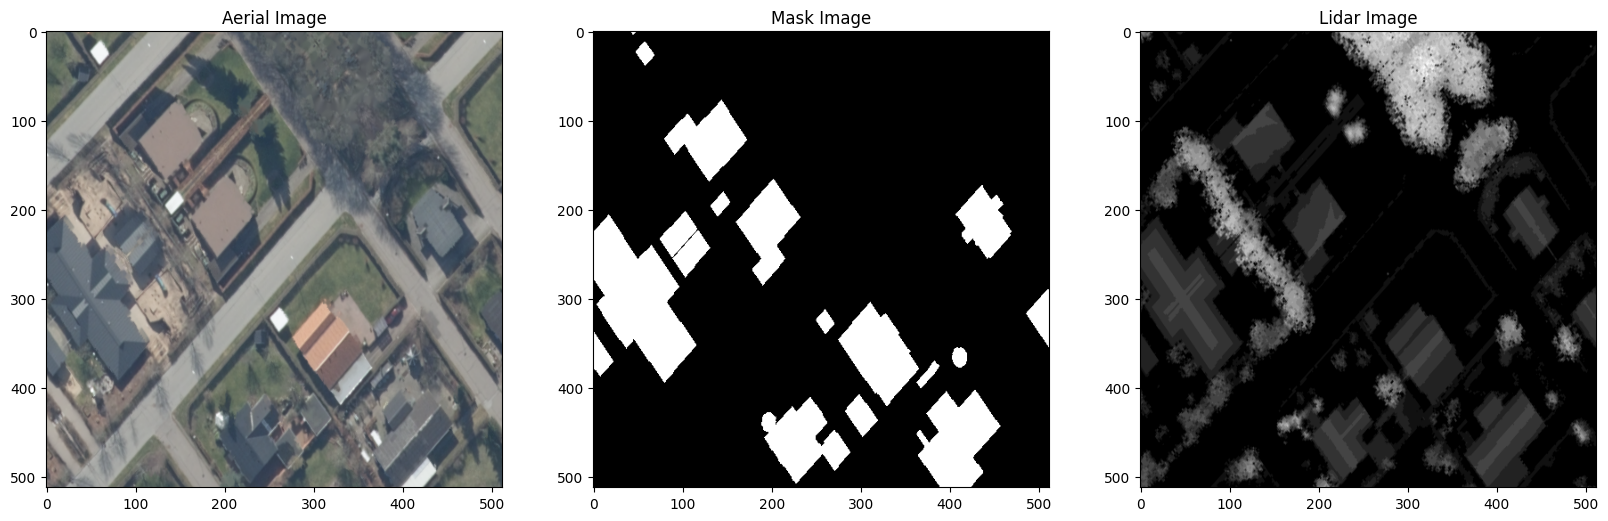

In [16]:
imggen = image_generator.next()
maskkgen = mask_generator.next()
for i in range(0,1):
    plt.figure(figsize=(20,20))
    image = imggen[i]
    mask = maskkgen[i]
    
    # Find and display aerial image
    plt.subplot(131)
    plt.title('Aerial Image')
    aerial_img = cv.cvtColor(image[:, :, 0:3], cv.COLOR_BGR2RGB)
    plt.imshow(aerial_img.astype(np.uint8))
    
    # Find and display mask image
    plt.subplot(132)
    plt.title('Mask Image')
    plt.imshow(mask, cmap='gray')
    
    # Find and display lidar image
    plt.subplot(133)
    plt.title('Lidar Image')
    plt.imshow(image[:, :, 3], cmap='gray')
    plt.show()

In [45]:
# Create callback for model.
# ModelCheckpoint -> Creates checkpoints after each epoch
# EarlyStopping -> Stops the training of the model if it doesnt improve after some epochs
callback_list = [
    callbacks.ModelCheckpoint(os.path.normpath('../models/MapAI_UNet_Task1_Checkpoint.h5'), verbose=1, save_best_only=True),
    callbacks.EarlyStopping(monitor='val_loss', patience=6),
    callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3, verbose=1)
]

# Train the model
results = model.fit(train_generator, steps_per_epoch=train_steps_per_epoch, epochs=100, callbacks=callback_list, validation_data=val_generator, validation_steps=val_steps_per_epoch)


Epoch 1/100


KeyboardInterrupt: 